In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud
from transformers import pipeline
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from google.colab import drive


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

LOAD THE DATA

In [6]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/twitter_dataset.csv')

#drop timestamp column
df=df.drop(columns=['Timestamp'])

df.head()

,Tweet_ID,Username,Text,Retweets,Likes
0,1,julie81,Party least receive say or single. Prevent pre...,2,25
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18
4,5,carlwarren,Involve sense former often approach government...,27,80


PRE PROCESSING

In [7]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()




1.   Remove unnecessary elements like URLs, hashtags, mentions, and special characters from the Text column.
2.   Convert text to lowercase for uniformity.
3.   Perform tokenization to split the text into individual words or phrases.
4.   Handling Stopwords: Remove common stopwords (like "the", "and", "in") that do not contribute to the sentiment.
5.   Lemmatization/Stemming: Reduce words to their base or root form (e.g., "running" to "run").



In [8]:
def clean_text(text):
    # Ensure text is a string
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r'\@\w+|\#', '', text)

    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Remove extra spaces and new lines
    text = re.sub(r'\s+', ' ', text).strip()

    # Convert text to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Apply the clean_text function to the 'Text' column
df['Cleaned_Text'] = df['Text'].apply(clean_text)

In [9]:
# View the processed dataset
print(df[['Text', 'Cleaned_Text']].head())

                                                Text  \
0  Party least receive say or single. Prevent pre...   
1  Hotel still Congress may member staff. Media d...   
2  Nice be her debate industry that year. Film wh...   
3  Laugh explain situation career occur serious. ...   
4  Involve sense former often approach government...   

                                        Cleaned_Text  
0  party least receive say single prevent prevent...  
1  hotel still congress may member staff medium d...  
2  nice debate industry year film generation push...  
3  laugh explain situation career occur serious f...  
4  involve sense former often approach government...  


In [10]:
# Save the cleaned dataset (optional)
# saving cleaned data into csv file is optional, you may proceed without creating it.
df.to_csv('cleaned_twitter_dataset.csv', index=False)

In [11]:
# Load the cleaned dataset
df_cleaned = pd.read_csv('/content/cleaned_twitter_dataset.csv')

EXPLORATORY DATA ANALYSIS(EDA)

In [12]:
# Check if sentiment labels are available
if 'Sentiment' in df_cleaned.columns:
    sentiment_counts = df_cleaned['Sentiment'].value_counts()
    sentiment_counts.plot(kind='bar')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()
else:
    print("No sentiment labels available in the dataset.")

No sentiment labels available in the dataset.


[('mr', 684), ('hard', 420), ('tax', 412), ('add', 399), ('maybe', 397), ('high', 397), ('food', 396), ('yard', 395), ('forget', 394), ('senior', 394), ('success', 393), ('scene', 393), ('job', 392), ('young', 392), ('man', 392), ('boy', 390), ('edge', 390), ('teach', 389), ('check', 389), ('exactly', 389)]


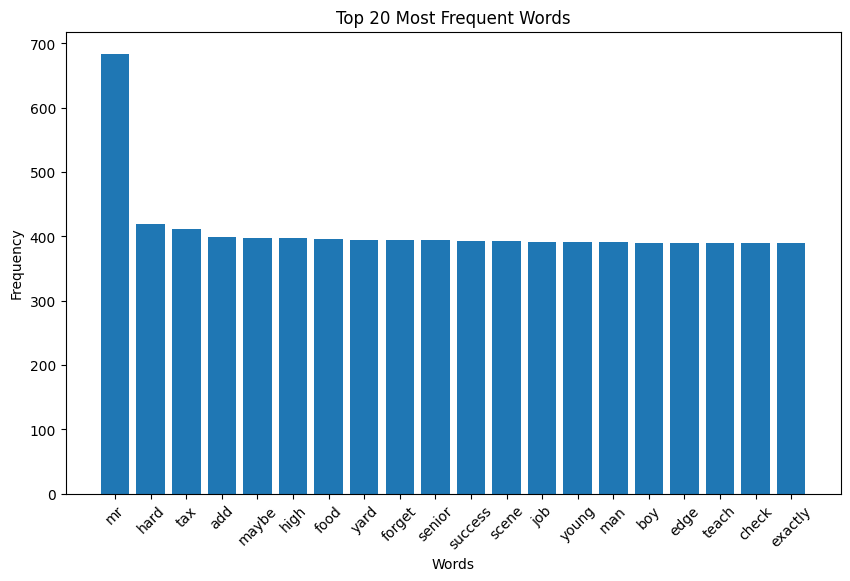

In [13]:
# Combine all cleaned text into a single string
all_text = ' '.join(df_cleaned['Cleaned_Text'])

# Tokenize the combined text
tokens = word_tokenize(all_text)

# Count word frequencies
word_freq = Counter(tokens)

# Display the most common words
common_words = word_freq.most_common(20)
print(common_words)

# Plot word frequencies
words, frequencies = zip(*common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


Word 'mr' has appeared more frequently than others

In [14]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return [' '.join(gram) for gram in n_grams]

# Get bigrams and trigrams
bigrams = get_ngrams(all_text, 2)
trigrams = get_ngrams(all_text, 3)

# Count and display the most common bigrams and trigrams
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

common_bigrams = bigram_freq.most_common(10)
common_trigrams = trigram_freq.most_common(10)

print("Most Common Bigrams:")
print(common_bigrams)

print("Most Common Trigrams:")
print(common_trigrams)


Most Common Bigrams:
[('father return', 6), ('parent various', 6), ('big seven', 6), ('early subject', 5), ('early would', 5), ('skin picture', 5), ('series across', 5), ('ahead receive', 5), ('everyone program', 5), ('political low', 5)]
Most Common Trigrams:
[('share last morning', 2), ('decide knowledge return', 2), ('hard rate figure', 2), ('seem work institution', 2), ('eye history risk', 2), ('sport drug mind', 2), ('represent work today', 2), ('within space south', 2), ('office major east', 2), ('policy speak strong', 2)]


The most common bigrams and trigrams suggest that the text contains varied and potentially complex topics, with phrases like "father return," "political low," and "sport drug mind" hinting at discussions around family, politics, health, and social issues. The low frequency of trigrams indicates that specific phrase patterns are not overly repetitive, suggesting diverse content.

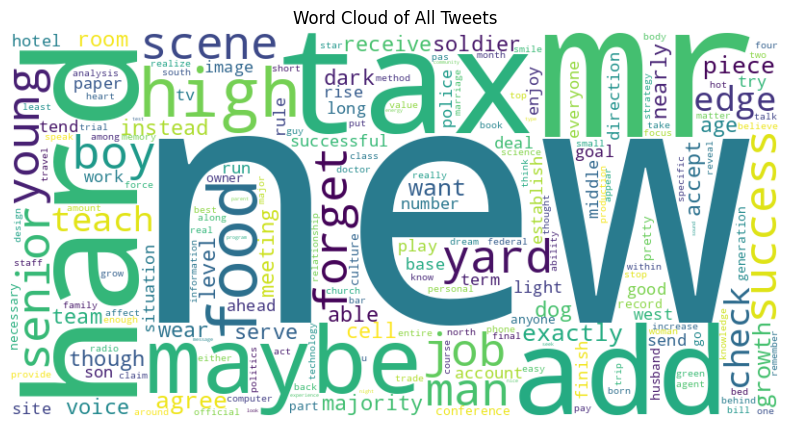

In [15]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Tweets')
plt.show()


Word cloud represents most frequently occured words

In [19]:
# Initialize a sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Apply the sentiment analysis pipeline to your dataset
df['Sentiment'] = df['Cleaned_Text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Map sentiment labels to numerical values (optional, if needed for model training)
label_mapping = {'POSITIVE': 1, 'NEGATIVE': 0, 'NEUTRAL': 2}  # Adjust labels based on the model's output
df['Sentiment_Num'] = df['Sentiment'].map(label_mapping)

# View the processed dataset
print(df[['Cleaned_Text', 'Sentiment', 'Sentiment_Num']].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                        Cleaned_Text Sentiment  Sentiment_Num
0  party least receive say single prevent prevent...  NEGATIVE              0
1  hotel still congress may member staff medium d...  NEGATIVE              0
2  nice debate industry year film generation push...  POSITIVE              1
3  laugh explain situation career occur serious f...  POSITIVE              1
4  involve sense former often approach government...  NEGATIVE              0


               Retweets     Likes  Sentiment_Num
Retweets       1.000000  0.012798      -0.005442
Likes          0.012798  1.000000       0.008938
Sentiment_Num -0.005442  0.008938       1.000000


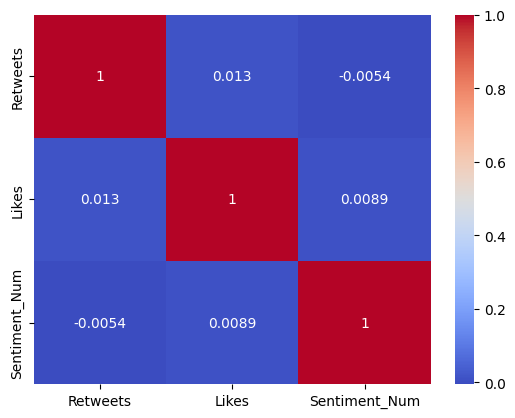

In [21]:
# Encode the sentiment labels into numerical values if not already done
df['Sentiment_Num'] = df['Sentiment'].factorize()[0]

# Calculate the correlation matrix
correlation_matrix = df[['Retweets', 'Likes', 'Sentiment_Num']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


Above correlation matrix confirms that  'Retweets' and 'Likes' features have very correlation with sentiment_num.
This indicates that these numerical features (Retweets and Likes) might not significantly contribute

In [22]:
# Display a sample of the dataset for manual review
sample_df = df[['Cleaned_Text', 'Sentiment', 'Sentiment_Num']].sample(10, random_state=1)  # Sample 10 random rows
print(sample_df)


                                           Cleaned_Text Sentiment  \
9953  factor enjoy property world main despite grow ...  POSITIVE   
3850  television sure others water hold value econom...  POSITIVE   
4962  structure trip professional offer chair break ...  NEGATIVE   
3886  walk method city statement check analysis chil...  NEGATIVE   
5437  single bed cover nearly let feeling side docto...  NEGATIVE   
8517  section education property mouth main capital ...  NEGATIVE   
2041  even full although man maintain member candida...  POSITIVE   
1989  good dinner save history trial address similar...  POSITIVE   
1933  interesting public focus today turn small movi...  POSITIVE   
9984  become challenge low performance exist range o...  POSITIVE   

      Sentiment_Num  
9953              1  
3850              1  
4962              0  
3886              0  
5437              0  
8517              0  
2041              1  
1989              1  
1933              1  
9984              1 

MODEL TRAINING AND EVALUATION

Model used is pre-trained BERT

Train test split


In [23]:
# Prepare features and labels
X = df['Cleaned_Text']
y = df['Sentiment_Num']  # Ensure sentiment labels are in numerical format

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text
def tokenize_and_encode(texts, max_length=128):
    return tokenizer(texts.tolist(),
                     padding='max_length',
                     truncation=True,
                     max_length=max_length,
                     return_tensors='pt')

# Encode train and test data
train_encodings = tokenize_and_encode(X_train)
test_encodings = tokenize_and_encode(X_test)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Training the model

In [26]:
# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train.tolist())
test_labels = torch.tensor(y_test.tolist())

# Create datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Load pre-trained BERT model with a sequence classification head
#i have three sentiment classes:positive,negative and neutral
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Adjust num_labels based on your sentiment classes

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-26-b7c563fe43df>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-26-b7c563fe43df>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss
500,0.580400
1000,0.492500
1500,0.405900
2000,0.371200
2500,0.268000
3000,0.225000


<ipython-input-26-b7c563fe43df>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-26-b7c563fe43df>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-26-b7c563fe43df>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-26-b7c563fe43df>:16: UserWarning: To copy construct from a tensor, it is recommende

TrainOutput(global_step=3000, training_loss=0.39049814860026044, metrics={'train_runtime': 659.8663, 'train_samples_per_second': 36.371, 'train_steps_per_second': 4.546, 'total_flos': 1578680506368000.0, 'train_loss': 0.39049814860026044, 'epoch': 3.0})

prediction on test dataset

In [30]:
# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# The predictions are logits, so you need to convert them to label indices
pred_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Get unique predicted labels
unique_labels = torch.unique(pred_labels)
print("Unique predicted labels:", unique_labels)



<ipython-input-26-b7c563fe43df>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-26-b7c563fe43df>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Unique predicted labels: tensor([0, 1])


Evaluating the model

In [33]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation results:", results)

# Predict on test set
test_preds = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(test_preds.predictions), axis=1)

# Check unique classes in predictions
unique_labels = torch.unique(pred_labels).numpy()
print("Unique predicted labels:", unique_labels)

# Adjust target names if necessary
if len(unique_labels) == 2:
    available_classes = ['NEGATIVE', 'POSITIVE']  # Adjust if only two classes are present
else:
    available_classes = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']

# Print classification report
print(classification_report(y_test, pred_labels.numpy(), target_names=available_classes))


<ipython-input-26-b7c563fe43df>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-26-b7c563fe43df>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Evaluation results: {'eval_loss': 0.6279669404029846, 'eval_runtime': 14.8298, 'eval_samples_per_second': 134.864, 'eval_steps_per_second': 16.858, 'epoch': 3.0}
Unique predicted labels: [0 1]
              precision    recall  f1-score   support

    NEGATIVE       0.91      0.89      0.90      1532
    POSITIVE       0.67      0.70      0.68       468

    accuracy                           0.85      2000
   macro avg       0.79      0.80      0.79      2000
weighted avg       0.85      0.85      0.85      2000



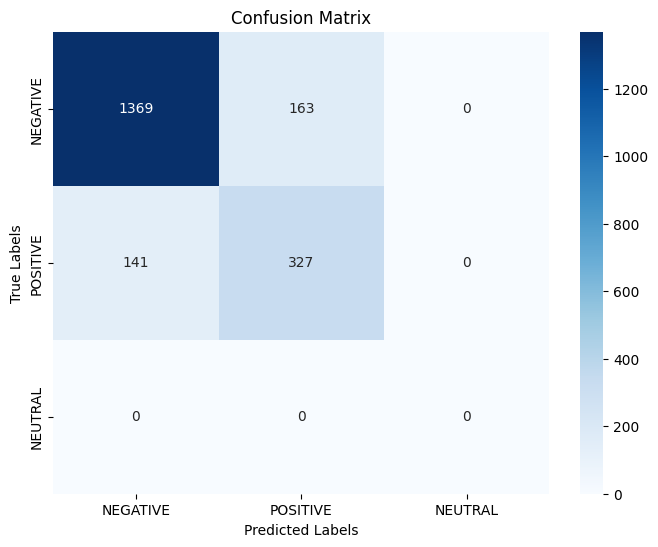

In [38]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_labels.numpy(), labels=[0, 1, 2])  # Use numerical labels

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NEGATIVE','POSITIVE', 'NEUTRAL'], yticklabels=['NEGATIVE','POSITIVE', 'NEUTRAL'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Conclusion:


1.   The above confusion matrix shows that there are no neutral texts
2.   The final result accuracy of the pre-trained model BERT is 85%



